In [1]:
%load_ext jupyternotify
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import import_ipynb

from sklearn.model_selection import KFold
from tqdm.auto import tqdm


import functions as func

pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

importing Jupyter notebook from functions.ipynb
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
raw_data = pd.read_csv('../data/data_neutral.csv', index_col=[0])

In [3]:
data = raw_data.copy()

In [4]:
data.head()

,pitcher,player_name,throws_right,release_pos_x,release_pos_z,fastball_2pct,breaking_2pct,off_speed_2pct,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,OSwing_pct,K_9,hit_9,BB_9,HR_9,release_speed_breaking,release_speed_fastball,release_speed_off_speed,pfx_x_breaking,pfx_x_fastball,pfx_x_off_speed,pfx_z_breaking,pfx_z_fastball,pfx_z_off_speed,release_spin_rate_breaking,release_spin_rate_fastball,release_spin_rate_off_speed,spin_axis_fastball,spin_axis_off_speed
0,282332,"Sabathia, CC",0,-2.315865,5.899743,0.596050,0.277678,0.126272,86.436909,0.135647,0.419558,0.189274,0.318612,0.072555,0.227384,0.295455,9.000000,9.420561,3.532710,2.271028,79.214871,88.547490,82.674408,-0.905711,0.293876,0.735024,0.102931,0.830402,0.645924,2208.381466,2156.420683,1884.739336,194.813253,228.061611
1,407845,"Rodney, Fernando",1,-2.164653,6.046254,0.679623,0.032980,0.287397,87.611628,0.116279,0.527132,0.217054,0.178295,0.077519,0.222222,0.306522,9.517986,9.323741,5.244604,0.971223,86.257143,93.801906,82.965164,0.189286,-0.923969,-1.259139,0.615357,1.166707,0.643811,2253.607143,2085.337955,1751.614754,218.008666,242.942623
2,425794,"Wainwright, Adam",1,-1.339804,6.171098,0.599158,0.363931,0.036911,88.176289,0.123711,0.486254,0.231100,0.224227,0.056701,0.176648,0.264175,8.077686,8.256198,2.856198,1.071074,74.087055,87.814780,82.926754,1.451246,-0.325698,-1.164254,-1.119364,0.815742,0.648728,2792.212189,2263.033234,1733.600877,187.216428,228.030702
3,425844,"Greinke, Zack",1,-1.269014,6.336909,0.461538,0.314077,0.224385,87.213761,0.125880,0.465989,0.231431,0.226740,0.071931,0.202007,0.303299,7.542594,8.164236,1.574827,1.077513,77.142191,89.339069,86.774393,0.794046,-0.230577,-1.056294,-0.363297,1.342422,0.347689,2421.696579,2284.299258,1692.246357,193.415655,238.265094
4,429719,"Jackson, Edwin",1,-1.842316,5.938597,0.651074,0.273006,0.075920,90.920732,0.211382,0.434959,0.268293,0.215447,0.081301,0.205298,0.239658,6.916256,13.965517,4.655172,3.059113,84.938764,92.717197,86.971717,0.286489,-0.398363,-1.319394,0.051910,0.947727,1.055556,2321.207865,2264.943463,2221.454545,197.404005,231.161616


# 1. Initial Processing
## 1.1 Preperation for Prediction Function

In [5]:
# create pitcher ID list
cluster = data[data.columns[:1]].copy()

### New Batters/Pitchers List

In [6]:
data_RV = pd.read_csv('../data/data_RV.csv', index_col=[0])

data_RV['PA_count'] = 1

# seperate last month of 2021 as test data
test_df = data_RV[data_RV['game_date']>='2021-09-01'].copy()
train_full_df = data_RV[data_RV['game_date']<'2021-09-01'].copy()

# create new batters/pitchers list
pitchers_all = data_RV['pitcher'].unique()
pitchers_old = cluster['pitcher'].to_list()
pitchers_new = [p for p in pitchers_all if p not in pitchers_old]

batters_new = train_full_df.groupby('batter').agg({'PA_count':sum}).reset_index()
batters_new = batters_new[batters_new['PA_count']<100]['batter'].to_list()

## 1.2 Train/Val Split

In [7]:
from sklearn.model_selection import train_test_split
# 20/80 train/val split
train_df, val_df = train_test_split(
     train_full_df, test_size=0.2, random_state=0, shuffle=True)

In [8]:
print(f"Num train: {train_df.shape[0]}")
print(f"Num validation: {val_df.shape[0]}")
print(f"Num test: {test_df.shape[0]}")

Num train: 311453
Num validation: 77864
Num test: 32522


## 1.3 Standard-scale data

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [10]:
data_std = data.copy()
for i in data.columns[3:]:
    data_std[i] = scaler.fit_transform(data[[i]])

data_std.head()

,pitcher,player_name,throws_right,release_pos_x,release_pos_z,fastball_2pct,breaking_2pct,off_speed_2pct,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,OSwing_pct,K_9,hit_9,BB_9,HR_9,release_speed_breaking,release_speed_fastball,release_speed_off_speed,pfx_x_breaking,pfx_x_fastball,pfx_x_off_speed,pfx_z_breaking,pfx_z_fastball,pfx_z_off_speed,release_spin_rate_breaking,release_spin_rate_fastball,release_spin_rate_off_speed,spin_axis_fastball,spin_axis_off_speed
0,282332,"Sabathia, CC",0,-0.547886,0.107543,0.109660,-0.049288,-0.055396,-1.212597,-0.123259,-0.360197,-0.891727,1.707820,-0.540799,0.088381,0.663420,0.090509,0.413008,-0.364793,1.587126,-0.861799,-1.734511,-0.974182,-1.946140,0.843609,1.253149,0.675416,-0.830334,0.117681,-0.893905,-0.560386,0.558454,-1.087490,-0.487359
1,407845,"Rodney, Fernando",1,-0.325049,0.412105,0.844812,-1.943539,1.407994,-0.474276,-0.723315,1.009887,-0.056674,-1.214032,-0.399936,-0.028721,0.980175,0.356909,0.354362,0.887441,-0.777481,1.150140,0.379045,-0.877219,-0.129367,-0.781237,-0.763319,1.820443,0.186724,0.111367,-0.706723,-1.016363,0.063014,0.311044,0.400184
2,425794,"Wainwright, Adam",1,0.890503,0.671624,0.136999,0.618410,-0.866996,-0.119382,-0.493045,0.489261,0.365527,-0.257578,-0.990677,-1.062663,-0.231836,-0.383837,-0.292282,-0.859654,-0.595831,-2.326788,-2.029239,-0.890028,1.964424,0.016974,-0.667373,-2.055827,-0.874668,0.126060,1.522478,0.123506,-0.004027,-1.545530,-0.489203
3,425844,"Greinke, Zack",1,0.994824,1.016306,-1.073580,0.232480,0.835699,-0.724339,-0.425868,0.231157,0.375481,-0.205252,-0.558506,-0.487349,0.887941,-0.659035,-0.347987,-1.796965,-0.584117,-1.453952,-1.416104,0.393099,0.874025,0.143885,-0.558205,-0.366380,0.718123,-0.773582,-0.011027,0.259922,-0.157933,-1.171757,0.121204
4,429719,"Jackson, Edwin",1,0.149968,0.188311,0.593676,-0.085454,-0.512703,1.605523,2.223208,-0.164046,1.483538,-0.440398,-0.292634,-0.412679,-0.933544,-0.981161,3.166031,0.456277,3.020812,0.773486,-0.057273,0.458904,0.031908,-0.079974,-0.824248,0.561409,-0.475518,1.341846,-0.426934,0.135760,1.811583,-0.931285,-0.302467


## 1.4 Feature Subsets

In [11]:
full = ['release_pos_x', 'release_pos_z', 'fastball_2pct', 'breaking_2pct', 'off_speed_2pct',
        'launch_speed', 'solid_rate', 'GB_rate', 'LD_rate', 'FB_rate', 'PU_rate', 'whiff_rate', 
        'OSwing_pct', 'K_9', 'hit_9', 'BB_9', 'HR_9', 'release_speed_breaking', 'release_speed_fastball',
        'release_speed_off_speed', 'pfx_x_breaking', 'pfx_x_fastball', 'pfx_x_off_speed', 
        'pfx_z_breaking', 'pfx_z_fastball', 'pfx_z_off_speed', 'release_spin_rate_breaking',
        'release_spin_rate_fastball', 'release_spin_rate_off_speed', 'spin_axis_fastball', 'spin_axis_off_speed']

player = ['release_pos_x', 'release_pos_z', 'fastball_2pct', 'breaking_2pct', 'off_speed_2pct']

swing = ['whiff_rate', 'OSwing_pct']

contact = ['launch_speed', 'solid_rate', 'GB_rate', 'LD_rate', 'FB_rate', 'PU_rate']

production = ['K_9', 'hit_9', 'BB_9', 'HR_9']

pitch = ['release_speed_breaking', 'release_speed_fastball', 'release_speed_off_speed', 
         'pfx_x_breaking', 'pfx_x_fastball', 'pfx_x_off_speed', 'pfx_z_breaking', 'pfx_z_fastball',
         'pfx_z_off_speed', 'release_spin_rate_breaking', 'release_spin_rate_fastball', 
         'release_spin_rate_off_speed', 'spin_axis_fastball', 'spin_axis_off_speed']

## 1.5 Functions
### Multi CV
#### Perform cross validation on each number of clusters.

labels: a dictionary with keys from 1 to n, each contains the pitcher grouping label produced by the model. This function will perform a 5-fold CV n times.

In [12]:
def multi_cross_val(labels):
    
    RV_test = [] # list of true RV which is constant
    RV_pred = [] # list of predicted xRV for each num of cluster labeling
    RV_league = [] # list of predicted league xRV
    errors = [] # errors list
    errors_pct = [] # erros pct list
    erros_league = [] # league errors list
    erros_league_pct = [] # league errors pct list
    
    
    for i in tqdm(labels): # loop through labels dictionary
        label = labels[i]
        func.cross_val(train_full_df, cluster, pitchers_new, batters_new, label, num_fold=5)

        RV_test.append(func.cross_val.RV_test_avg)
        RV_pred.append(func.cross_val.RV_pred_avg)
        RV_league.append(func.cross_val.RV_league_avg)
        errors.append(func.cross_val.error_avg)
        errors_pct.append(func.cross_val.error_pct_avg)
        erros_league.append(func.cross_val.errorLeague_avg)
        erros_league_pct.append(func.cross_val.errorLeague_pct_avg)

    # save results as function attributes
    multi_cross_val.RV_test = RV_test
    multi_cross_val.RV_pred = RV_pred
    multi_cross_val.RV_league = RV_league
    multi_cross_val.errors = errors
    multi_cross_val.errors_pct = errors_pct
    multi_cross_val.erros_league = erros_league
    multi_cross_val.erros_league_pct = erros_league_pct
    
    return multi_cross_val

### Plot Results Chart
#### Plot one error pct line graph on the left, and one predicted vs true RV line graph on the right

results: function object which contains multi CV results

model_name: string of model name for graph legend

features_set: string of features subset as graph title

In [13]:
def plot_charts(results, model_name, features_set):
    plt.style.use('seaborn')
    
    x = [x for x in range(1,len(results.errors_pct)+1)]
    fig, ax = plt.subplots(1,2, figsize=(13,6))
    fig.suptitle(features_set, fontsize=20)
    sns.lineplot(x=x, y=results.errors_pct, ax=ax[0])
    sns.lineplot(x=x, y=results.erros_league_pct, ax=ax[0])
    ax[0].legend([model_name, 'league average'])
    sns.lineplot(x=x, y=results.RV_pred, ax=ax[1])
    sns.lineplot(x=x, y=results.RV_league, ax=ax[1])
    sns.lineplot(x=x, y=results.RV_test, ax=ax[1])
    ax[1].legend([model_name, 'league average', 'true RV'])
    ax[0].set(xlabel='Number of Clusters',
           ylabel='Error Percentage',
           title='RV Prediction Error')
    ax[1].set(xlabel='Number of Clusters',
           ylabel='Season Avg RV',
           title='Season Avg RV')
    plt.show()

# 2. Cluster Modeling
### PCA (used in cluster_analysis.ipynb)

In [14]:
# from sklearn.decomposition import PCA

In [15]:
# X = data_std[full]

# pca = PCA(n_components=10).fit(X)
# transformed = pca.transform(X)
# print(transformed.shape)

In [16]:
# xs = transformed[:,0]
# ys = transformed[:,1]
# plt.scatter(xs, ys, alpha=0.7)
# plt.show()

In [17]:
# features = range(pca.n_components_)

# plt.bar(features, pca.explained_variance_)
# plt.ylabel('variance')
# plt.xlabel('PCA feature')
# plt.show()

In [18]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

## 2.1 K-means

In [19]:
from sklearn.cluster import KMeans

### Full Features

In [20]:
X = data_std[full]
sse = {}
labels_KM_full = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_full[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

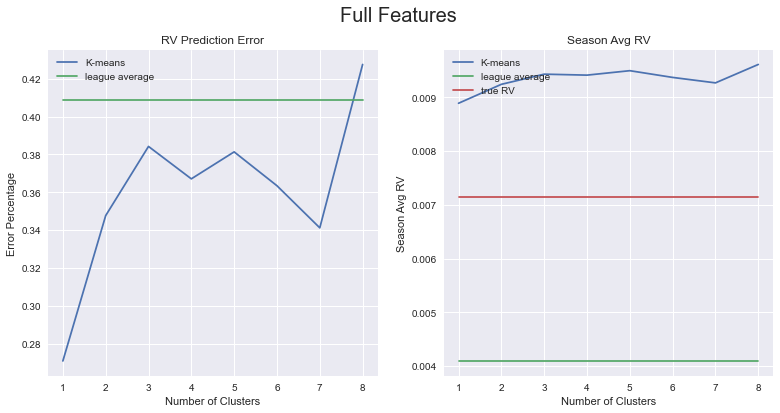

In [21]:
KM_Full = multi_cross_val(labels_KM_full)
KM_Full_error_pct = KM_Full.errors_pct
plot_charts(KM_Full, 'K-means', 'Full Features')

### Production

In [22]:
X = data_std[production]
sse = {}
labels_KM_prod = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_prod[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

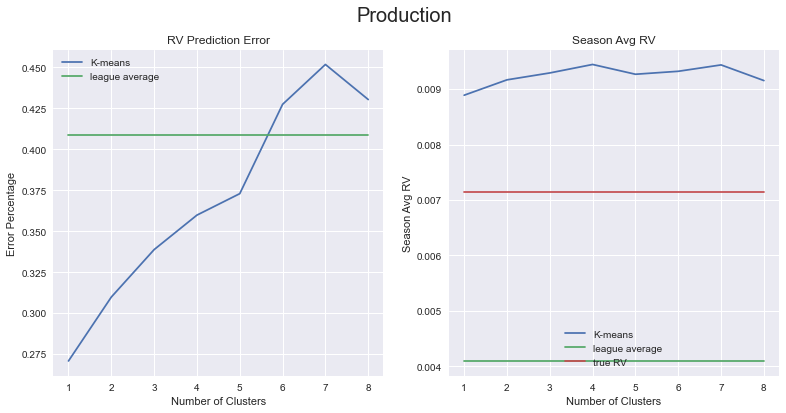

In [23]:
KM_Prod = multi_cross_val(labels_KM_prod)
KM_Prod_error_pct = KM_Prod.errors_pct

plot_charts(KM_Prod, 'K-means', 'Production')

### Production + Contact

In [24]:
X = data_std[production+contact]
sse = {}
labels_KM_ProdCont = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_ProdCont[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

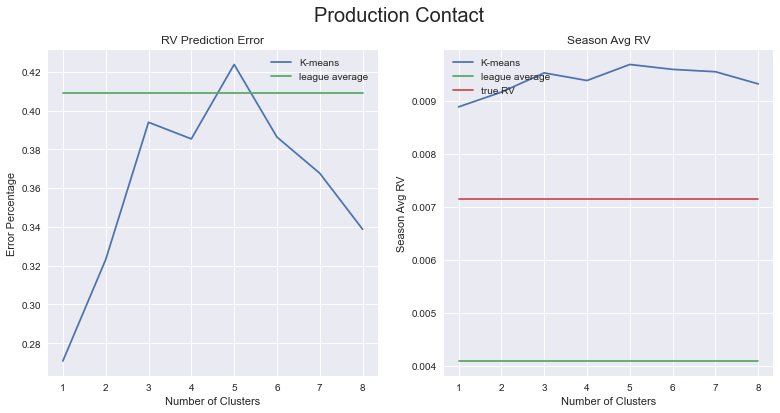

In [25]:
KM_ProdCont = multi_cross_val(labels_KM_ProdCont)
KM_ProdCont_error_pct = KM_ProdCont.errors_pct

plot_charts(KM_ProdCont, 'K-means', 'Production Contact')

### Production + Contact + Swing

In [26]:
X = data_std[production+contact+swing]

sse = {}
labels_KM_ProdContSwing = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_ProdContSwing[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

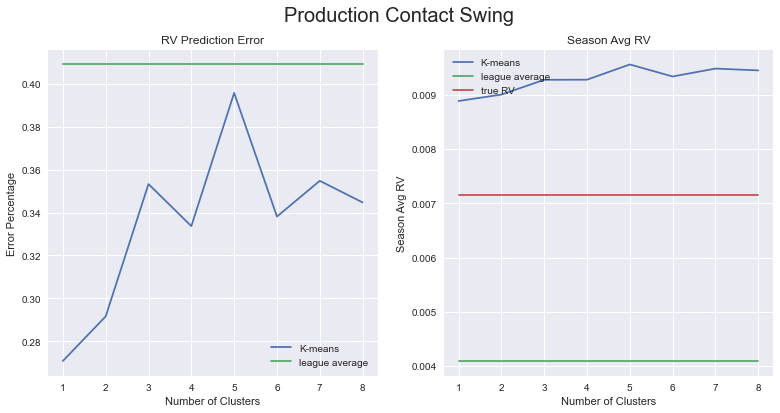

In [27]:
KM_ProdContSwing = multi_cross_val(labels_KM_ProdContSwing)
KM_ProdContSwing_error_pct = KM_ProdContSwing.errors_pct

plot_charts(KM_ProdContSwing, 'K-means', 'Production Contact Swing')

### Player + Production + Contact + Swing

In [28]:
X = data_std[player+production+contact+swing]

sse = {}
labels_KM_PlayerProdContSwing = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_PlayerProdContSwing[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

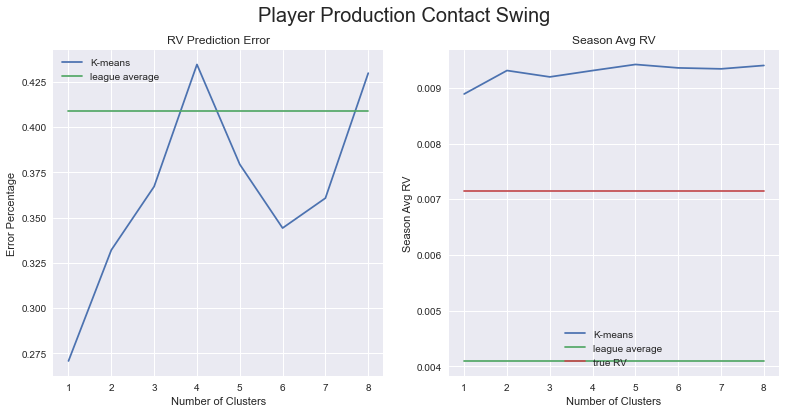

In [29]:
KM_PlayerProdContSwing = multi_cross_val(labels_KM_PlayerProdContSwing)
KM_PlayerProdContSwing_error_pct = KM_PlayerProdContSwing.errors_pct

plot_charts(KM_PlayerProdContSwing, 'K-means', 'Player Production Contact Swing')

### Production Player

In [30]:
X = data_std[production+player]

sse = {}
labels_KM_ProdPlayer = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_ProdPlayer[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

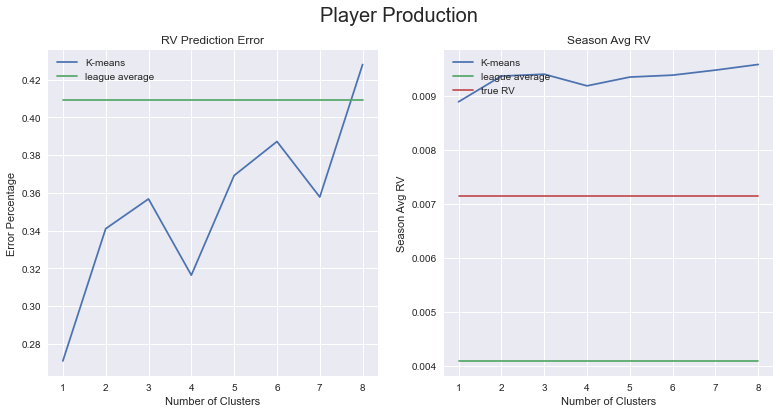

In [31]:
KM_ProdPlayer = multi_cross_val(labels_KM_ProdPlayer)
KM_ProdPlayer_error_pct = KM_ProdPlayer.errors_pct

plot_charts(KM_ProdPlayer, 'K-means', 'Player Production')

### Player Pitch

In [32]:
X = data_std[player+pitch]

sse = {}
labels_KM_PlayerPitch = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_PlayerPitch[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

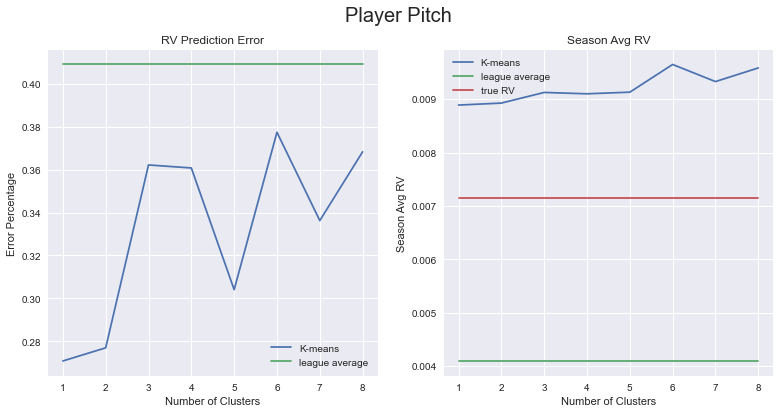

In [33]:
KM_PlayerPitch = multi_cross_val(labels_KM_PlayerPitch)
KM_PlayerPitch_error_pct = KM_PlayerPitch.errors_pct

plot_charts(KM_PlayerPitch, 'K-means', 'Player Pitch')

### Player + Prod + Pitch

In [34]:
X = data_std[player+production+pitch]

sse = {}
labels_KM_PlayerProdPitch = {}
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM_PlayerProdPitch[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

  0%|          | 0/8 [00:00<?, ?it/s]

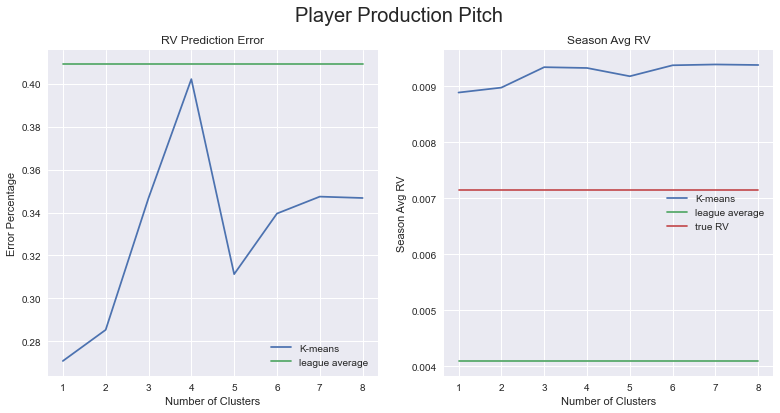

In [35]:
KM_PlayerProdPitch = multi_cross_val(labels_KM_PlayerProdPitch)
KM_PlayerProdPitch_error_pct = KM_PlayerProdPitch.errors_pct

plot_charts(KM_PlayerProdPitch, 'K-means', 'Player Production Pitch')

In [36]:
# sns.set_style("darkgrid")
# fig, ax = plt.subplots(figsize=(8,5))
# ax = sns.lineplot(x=sse.keys(), y=sse.values(), marker='o', color='red')

# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()

In [37]:
# pca = PCA(n_components=2).fit(X)
# transformed = pca.transform(X)
# xs = transformed[:,0]
# ys = transformed[:,1]
# plt.scatter(xs, ys, alpha=0.7, c=labels_KM_full[3])
# plt.show()

## 2.2 Hierarchical

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

## Functions

In [39]:
def produce_labels_HC(X, method='complete', metric='correlation', criterion='distance'):
    mergings = linkage(X, method=method, metric=metric)
    
    labels_HC = {}
    
    count = 0
    for i in np.arange(2,1.4, -0.01):
        n_unique = 0
        n_unique = len(set(fcluster(mergings, i, criterion=criterion)))
        if n_unique != count:
            labels_HC[n_unique] = fcluster(mergings, i, criterion=criterion)
        else:
            continue
        count = n_unique

        if n_unique <= 7:
            continue
        else:
            break
    return labels_HC, mergings

### Full Features

In [40]:
X = data_std[full]
labels_HC_full, mergings_full = produce_labels_HC(X)

  0%|          | 0/8 [00:00<?, ?it/s]

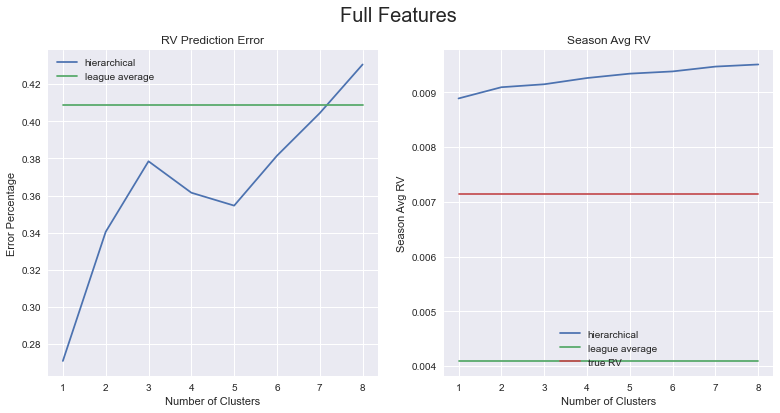

In [41]:
HC_Full = multi_cross_val(labels_HC_full)
HC_Full_error_pct = HC_Full.errors_pct

plot_charts(HC_Full, 'hierarchical', 'Full Features')

### Production

In [42]:
X = data_std[production]
labels_HC_Prod, mergings_Prod = produce_labels_HC(X)

  0%|          | 0/6 [00:00<?, ?it/s]

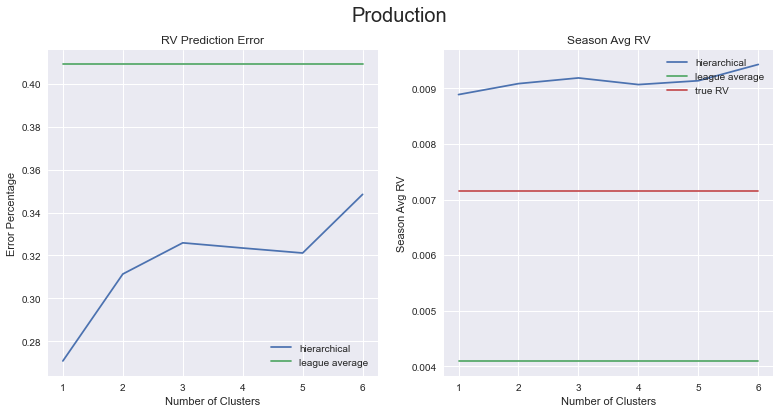

In [43]:
HC_Prod = multi_cross_val(labels_HC_Prod)
HC_Prod_errors_pct = HC_Prod.errors_pct

plot_charts(HC_Prod, 'hierarchical', 'Production')

### Contact

In [44]:
X = data_std[contact]
labels_HC_Cont, mergings_Cont = produce_labels_HC(X)

  0%|          | 0/6 [00:00<?, ?it/s]

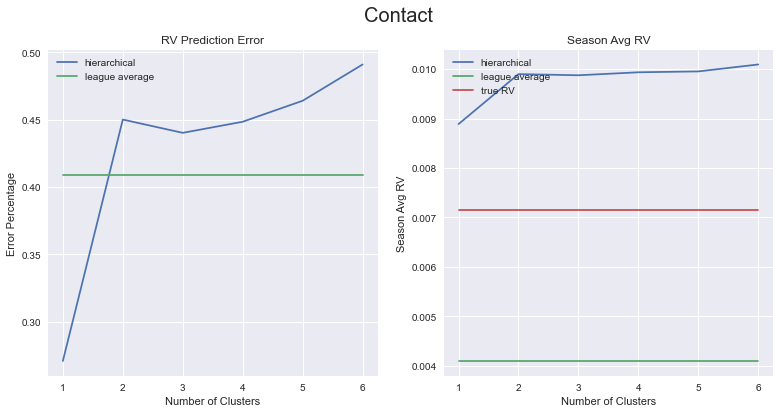

In [45]:
HC_Cont = multi_cross_val(labels_HC_Cont)
HC_Cont_errors_pct = HC_Cont.errors_pct

plot_charts(HC_Cont, 'hierarchical', 'Contact')

### Pitch

In [46]:
X = data_std[pitch]
labels_HC_Pitch, mergings_Pitch = produce_labels_HC(X)

  0%|          | 0/7 [00:00<?, ?it/s]

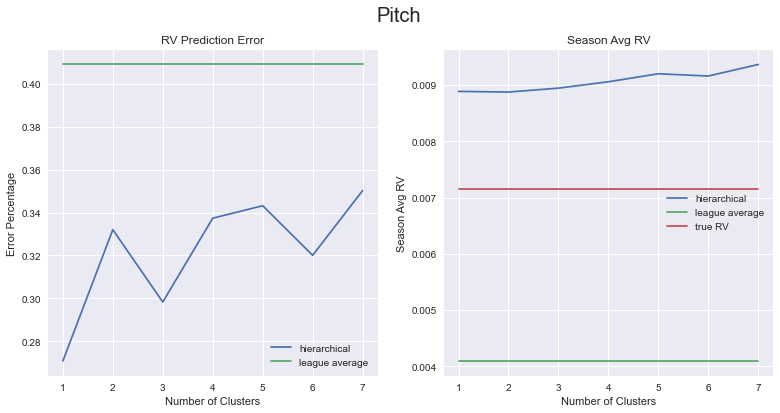

In [47]:
HC_Pitch = multi_cross_val(labels_HC_Pitch)
HC_Pitch_errors_pct = HC_Pitch.errors_pct

plot_charts(HC_Pitch, 'hierarchical', 'Pitch')

### Production+Contact

In [48]:
X = data_std[production+contact]
labels_HC_ProdCont, mergings_ProdCont = produce_labels_HC(X)

  0%|          | 0/8 [00:00<?, ?it/s]

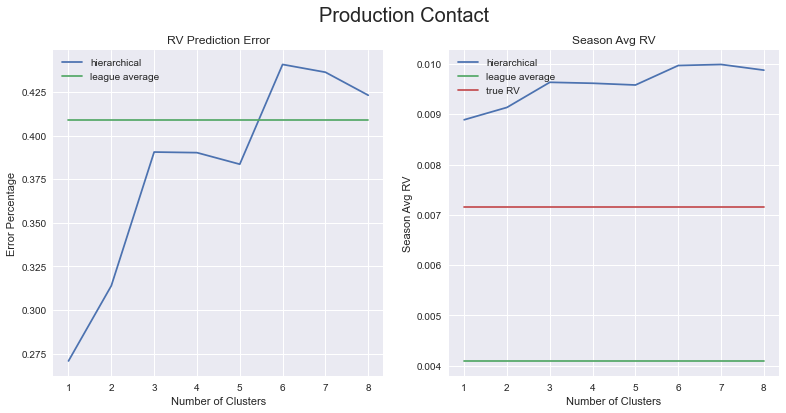

In [49]:
HC_ProdCont = multi_cross_val(labels_HC_ProdCont)
HC_ProdCont_errors_pct = HC_ProdCont.errors_pct

plot_charts(HC_ProdCont, 'hierarchical', 'Production Contact')

### Production + Player

In [50]:
X = data_std[production+player]
labels_HC_ProdPlayer, mergings_ProdPlayer = produce_labels_HC(X)

  0%|          | 0/7 [00:00<?, ?it/s]

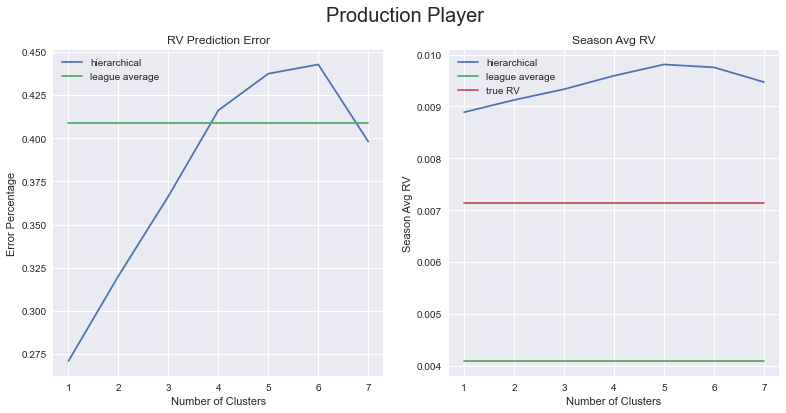

In [51]:
HC_ProdPlayer = multi_cross_val(labels_HC_ProdPlayer)
HC_ProdPlayer_errors_pct = HC_ProdPlayer.errors_pct

plot_charts(HC_ProdPlayer, 'hierarchical', 'Production Player')

### Player + Pitch

In [52]:
X = data_std[player+pitch]
labels_HC_PlayerPitch, mergings_PlayerPitch = produce_labels_HC(X)

In [ ]:
HC_PlayerPitch = multi_cross_val(labels_HC_PlayerPitch)
HC_PlayerPitch_errors_pct = HC_PlayerPitch.errors_pct

plot_charts(HC_PlayerPitch, 'hierarchical', 'Player Pitch')

  0%|          | 0/8 [00:00<?, ?it/s]

### Production + Contact + Swing

In [ ]:
X = data_std[production+contact+swing]
labels_HC_ProdContSwing, mergings_ProdContSwing = produce_labels_HC(X)

In [ ]:
HC_ProdContSwing = multi_cross_val(labels_HC_ProdContSwing)
HC_ProdContSwing_errors_pct = HC_ProdContSwing.errors_pct

plot_charts(HC_ProdContSwing, 'hierarchical', 'Production Contact Swing')

### Player + Production + Contact + Swing

In [ ]:
X = data_std[player+production+contact+swing]
labels_HC_PlayerProdContSwing, mergings_PlayerProdContSwing = produce_labels_HC(X)

In [ ]:
HC_PlayerProdContSwing = multi_cross_val(labels_HC_PlayerProdContSwing)
HC_PlayerProdContSwing_errors_pct = HC_PlayerProdContSwing.errors_pct

plot_charts(HC_PlayerProdContSwing, 'hierarchical', 'Player Production Contact Swing')

### Player+Production+Pitch

In [ ]:
X = data_std[player+production+pitch]
labels_HC_PlayerProdPitch, mergings_PlayerProdPitch = produce_labels_HC(X)

In [ ]:
HC_PlayerProdPitch = multi_cross_val(labels_HC_PlayerProdPitch)
HC_PlayerProdPitch_errors_pct = HC_PlayerProdPitch.errors_pct

plot_charts(HC_PlayerProdPitch, 'hierarchical', 'Player Production Pitch')

### Player + Contact + Pitch

In [ ]:
X = data_std[player+contact+pitch]
labels_HC_PlayerContPitch, mergings_PlayerContPitch = produce_labels_HC(X)

In [ ]:
HC_PlayerContPitch = multi_cross_val(labels_HC_PlayerContPitch)
HC_PlayerContPitch_errors_pct = HC_PlayerContPitch.errors_pct

plot_charts(HC_PlayerContPitch, 'hierarchical', 'Player Contact Pitch')

### Player Swing Pitch

In [ ]:
X = data_std[player+swing+pitch]
labels_HC_PlayerSwingPitch, mergings_PlayerSwingPitch = produce_labels_HC(X)

In [ ]:
HC_PlayerSwingPitch = multi_cross_val(labels_HC_PlayerSwingPitch)
HC_PlayerSwingPitch_errors_pct = HC_PlayerSwingPitch.errors_pct

plot_charts(HC_PlayerSwingPitch, 'hierarchical', 'Player Swing Pitch')

### Plot dendrogram

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
dn = dendrogram(mergings_PlayerProdPitch, leaf_rotation=90, leaf_font_size=3, ax=ax)
ax.set_title('Player Production Pitch', fontsize = 30)
plt.show()

In [ ]:
# # mergings = linkage(X, method='complete', metric='correlation')

# # fig, ax = plt.subplots(figsize=(20, 10))
# # dn = dendrogram(mergings, leaf_rotation=90, leaf_font_size=3, ax=ax)
# # plt.show()

# labels_HC = fcluster(mergings, 1.86, criterion='distance')
# set(labels_HC)

In [ ]:
# plt.hist(labels_HC_PlayerProdPitch[3])
# plt.show()

In [ ]:
# plt.style.use('default')

# pca = PCA(n_components=2).fit(X)
# transformed = pca.transform(X)
# xs = transformed[:,0]
# ys = transformed[:,1]
# plt.scatter(xs, ys, alpha=0.7, c=labels_HC_PlayerProdPitch[3])
# plt.show()

## 2.3 GMM

In [ ]:
from sklearn.mixture import GaussianMixture

### Produce Labels Function
#### Fit GMM with # of components from 1-7

In [ ]:
def produce_labels_GMM(X, max_iter=100):
    labels_GMM = {}
    for i in range(1,7):
        gmm = GaussianMixture(n_components=i, max_iter=100, random_state=0).fit(X)
        labels_GMM[i] = gmm.predict(X)
    return labels_GMM

### Full

In [ ]:
X = data_std[full]
labels_GMM_Full = produce_labels_GMM(X)

In [ ]:
GMM_Full = multi_cross_val(labels_GMM_Full)
GMM_Full_errors_pct = GMM_Full.errors_pct

plot_charts(GMM_Full, 'GMM', 'Full Features')

### Production

In [ ]:
X = data_std[production]
labels_GMM_Prod = produce_labels_GMM(X)

In [ ]:
GMM_Prod = multi_cross_val(labels_GMM_Prod)
GMM_Prod_errors_pct = GMM_Prod.errors_pct

plot_charts(GMM_Prod, 'GMM', 'Production')

### Contact

In [ ]:
X = data_std[contact]
labels_GMM_Cont = produce_labels_GMM(X)

In [ ]:
GMM_Cont = multi_cross_val(labels_GMM_Cont)
GMM_Cont_errors_pct = GMM_Cont.errors_pct

plot_charts(GMM_Cont, 'GMM', 'Contact')

### Production Contact

In [ ]:
X = data_std[production+contact]
labels_GMM_ProdCont = produce_labels_GMM(X)

In [ ]:
GMM_ProdCont = multi_cross_val(labels_GMM_ProdCont)
GMM_ProdCont_errors_pct = GMM_ProdCont.errors_pct

plot_charts(GMM_ProdCont, 'GMM', 'Production Contact')

### Production Contact Swing

In [ ]:
X = data_std[production+contact+swing]
labels_GMM_ProdContSwing = produce_labels_GMM(X)

In [ ]:
GMM_ProdContSwing = multi_cross_val(labels_GMM_ProdContSwing)
GMM_ProdContSwing_errors_pct = GMM_ProdContSwing.errors_pct

plot_charts(GMM_ProdContSwing, 'GMM', 'Production Contact Swing')

### Player Production Contact Swing

In [ ]:
X = data_std[player+production+contact+swing]
labels_GMM_PlayerProdContSwing = produce_labels_GMM(X)

In [ ]:
GMM_PlayerProdContSwing = multi_cross_val(labels_GMM_PlayerProdContSwing)
GMM_PlayerProdContSwing_errors_pct = GMM_PlayerProdContSwing.errors_pct

plot_charts(GMM_PlayerProdContSwing, 'GMM', 'Player Production Contact Swing')

### Production Player

In [ ]:
X = data_std[player+production]
labels_GMM_PlayerProd = produce_labels_GMM(X)

In [ ]:
GMM_PlayerProd = multi_cross_val(labels_GMM_PlayerProd)
GMM_PlayerProd_errors_pct = GMM_PlayerProd.errors_pct

plot_charts(GMM_PlayerProd, 'GMM', 'Production Player')

### Player Pitch

In [ ]:
X = data_std[player+pitch]
labels_GMM_PlayerPitch = produce_labels_GMM(X)

In [ ]:
GMM_PlayerPitch = multi_cross_val(labels_GMM_PlayerPitch)
GMM_PlayerPitch_errors_pct = GMM_PlayerPitch.errors_pct

plot_charts(GMM_PlayerPitch, 'GMM', 'Player Pitch')

### Player Contact Pitch

In [ ]:
X = data_std[player+contact+pitch]
labels_GMM_PlayerContPitch = produce_labels_GMM(X)

In [ ]:
GMM_PlayerContPitch = multi_cross_val(labels_GMM_PlayerContPitch)
GMM_PlayerContPitch_errors_pct = GMM_PlayerContPitch.errors_pct

plot_charts(GMM_PlayerContPitch, 'GMM', 'Player Contact Pitch')

### Player Production Pitch

In [ ]:
X = data_std[player+production+pitch]
labels_GMM_PlayerProdPitch = produce_labels_GMM(X)

In [ ]:
GMM_PlayerProdPitch = multi_cross_val(labels_GMM_PlayerProdPitch)
GMM_PlayerProdPitch_errors_pct = GMM_PlayerProdPitch.errors_pct

plot_charts(GMM_PlayerProdPitch, 'GMM', 'Player Production Pitch')

### Player Swing Pitch

In [ ]:
X = data_std[player+swing+pitch]
labels_GMM_PlayerSwingPitch = produce_labels_GMM(X)

In [ ]:
GMM_PlayerSwingPitch = multi_cross_val(labels_GMM_PlayerSwingPitch)
GMM_PlayerSwingPitch_errors_pct = GMM_PlayerSwingPitch.errors_pct

plot_charts(GMM_PlayerSwingPitch, 'GMM', 'Player Swing Pitch')

In [ ]:
# n_components = np.arange(1, 21)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
#           for n in n_components]

# plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components');

# 3. Model Selection
Based on training errors, the following 4 models were selected to make prediction on Validation and Train set:

1. HC1/num of clusters: 3/Features:Player Production Pitch
1. HC2/num of clusters: 2/Features: Player Pitch
1. GMM1/num of clusters: 3/Features: Player Contact Pitch
1. GMM2/num of clusters: 3/Features: Player Pitch

In [ ]:
# HC1 best training result:
np.array(HC_PlayerProdPitch_errors_pct).min()

In [ ]:
# HC2 best training result:
np.array(HC_PlayerPitch_errors_pct).min()

In [ ]:
# GMM1 best training result:
np.array(GMM_PlayerContPitch_errors_pct).min()

In [ ]:
# GMM2 best training result:
np.array(GMM_PlayerPitch_errors_pct).min()

# 4. Prediction on Validation Set
## HC1:

In [ ]:
func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_HC_PlayerProdPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## HC2:

In [ ]:
func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_HC_PlayerPitch[2])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## GMM1:

In [ ]:
func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_GMM_PlayerContPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## GMM2:

In [ ]:
func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_GMM_PlayerPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

In [ ]:
# func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_KM_full[3])
# print(f'RV True: {func.predict.RV_test_avg}')
# print(f'RV Pred: {func.predict.RV_pred_avg}')
# print(f'RV League: {func.predict.RV_league_avg}')
# print(f'RV Error Pct: {func.predict.error_pct}')
# print(f'RV League Error Pct: {func.predict.error_league_pct}')

In [ ]:
# func.predict(train_df, val_df, cluster, pitchers_new, batters_new, labels_KM_ProdPlayer[4])
# print(f'RV True: {func.predict.RV_test_avg}')
# print(f'RV Pred: {func.predict.RV_pred_avg}')
# print(f'RV League: {func.predict.RV_league_avg}')
# print(f'RV Error Pct: {func.predict.error_pct}')
# print(f'RV League Error Pct: {func.predict.error_league_pct}')

# 5. Test Set Prediction (Final)
## HC1:

In [ ]:
func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_HC_PlayerProdPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## HC2:

In [ ]:
func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_HC_PlayerPitch[2])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## GMM1:

In [ ]:
func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_GMM_PlayerContPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

## GMM2:

In [ ]:
func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_GMM_PlayerPitch[3])
print(f'RV True: {func.predict.RV_test_avg}')
print(f'RV Pred: {func.predict.RV_pred_avg}')
print(f'RV League: {func.predict.RV_league_avg}')
print(f'RV Error Pct: {func.predict.error_pct}')
print(f'RV League Error Pct: {func.predict.error_league_pct}')

In [ ]:
# func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_KM_full[3])
# print(f'RV True: {func.predict.RV_test_avg}')
# print(f'RV Pred: {func.predict.RV_pred_avg}')
# print(f'RV League: {func.predict.RV_league_avg}')
# print(f'RV Error Pct: {func.predict.error_pct}')
# print(f'RV League Error Pct: {func.predict.error_league_pct}')

In [ ]:
# func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_KM_ProdPlayer[4])
# print(f'RV True: {func.predict.RV_test_avg}')
# print(f'RV Pred: {func.predict.RV_pred_avg}')
# print(f'RV League: {func.predict.RV_league_avg}')
# print(f'RV Error Pct: {func.predict.error_pct}')
# print(f'RV League Error Pct: {func.predict.error_league_pct}')

In [ ]:
# func.predict(train_full_df, test_df, cluster, pitchers_new, batters_new, labels_KM_ProdPlayer[4])
# print(f'RV True: {func.predict.RV_test_avg}')
# print(f'RV Pred: {func.predict.RV_pred_avg}')
# print(f'RV League: {func.predict.RV_league_avg}')
# print(f'RV Error Pct: {func.predict.error_pct}')
# print(f'RV League Error Pct: {func.predict.error_league_pct}')

# Export Final Model for EDA

In [ ]:
cluster = data[data.columns[:1]].copy()
cluster['final_label'] = labels_GMM_PlayerContPitch[3]
final_cluster = cluster.copy()

In [ ]:
# final_cluster.to_csv('../data/final_cluster.csv')

In [ ]:
%%notify
pass